In [2]:
# Unnecessary on google colab
# %conda install pytorch torchvision -c pytorch
# %conda install -c fastai fastai

## Single-label chest cancer classification

### Import and clone dataset

In [3]:
from fastai.vision.all import *
from fastcore.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import f1_score
!git clone https://github.com/davay/data5100.git # unnecessary on local

Cloning into 'data5100'...
remote: Enumerating objects: 948, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 948 (delta 22), reused 18 (delta 4), pack-reused 902
Receiving objects: 100% (948/948), 92.40 MiB | 48.80 MiB/s, done.
Resolving deltas: 100% (29/29), done.


### Label and load images

In [ ]:
path = 'data' # local
# path = 'data5100/data' # google colab
dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            test = 'test',
                            item_tfms = Resize(450, pad_mode='zeros'),
                            # item_tfms = RandomResizedCrop(450, min_scale = 0.75), # imagenet models often use 224 x 224. Our images aren't 1:1 aspect ratio, by default center crop will be used. We can add pad_mode='zeros' for no cropping.
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)],
                            bs=32) # default is 64, local runs out of memory when used with densenet201

### Retrain model on new data set

epoch,train_loss,valid_loss,error_rate,time
0,1.845376,1.597392,0.694444,00:04
1,1.610467,1.250308,0.513889,00:04
2,1.401255,0.948624,0.402778,00:04
3,1.128252,0.833053,0.319444,00:04
4,0.917600,0.788187,0.263889,00:04
5,0.745823,0.743284,0.208333,00:04
6,0.596210,0.731734,0.222222,00:04
7,0.495814,0.682455,0.180556,00:04
8,0.408834,1.016871,0.236111,00:04
9,0.355584,0.820971,0.236111,00:04


No improvement since epoch 25: early stopping


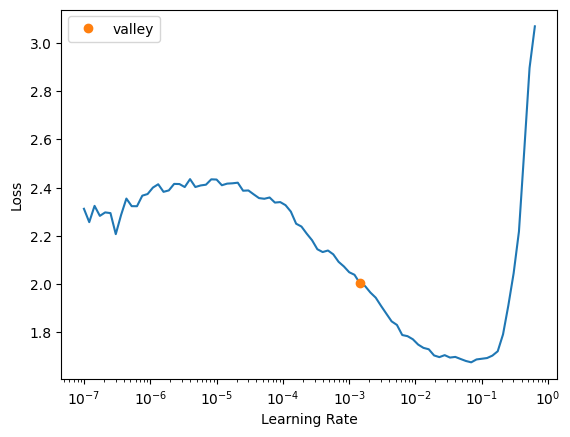

In [ ]:
learn = vision_learner(dls, densenet201, metrics=error_rate)
lr_valley = learn.lr_find().valley
epoch = 50
div = 25
# learn.fit_one_cycle(epoch, lr_valley)
learn.fit_one_cycle(epoch, lr_valley, div, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=10)])

### Evaluate performance of retrained model

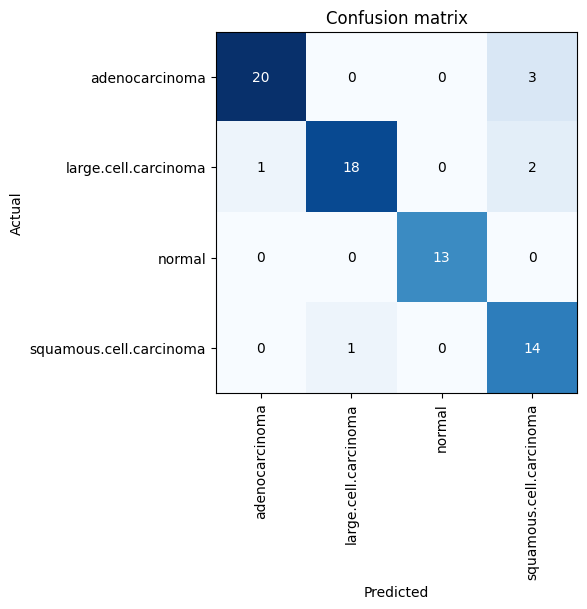

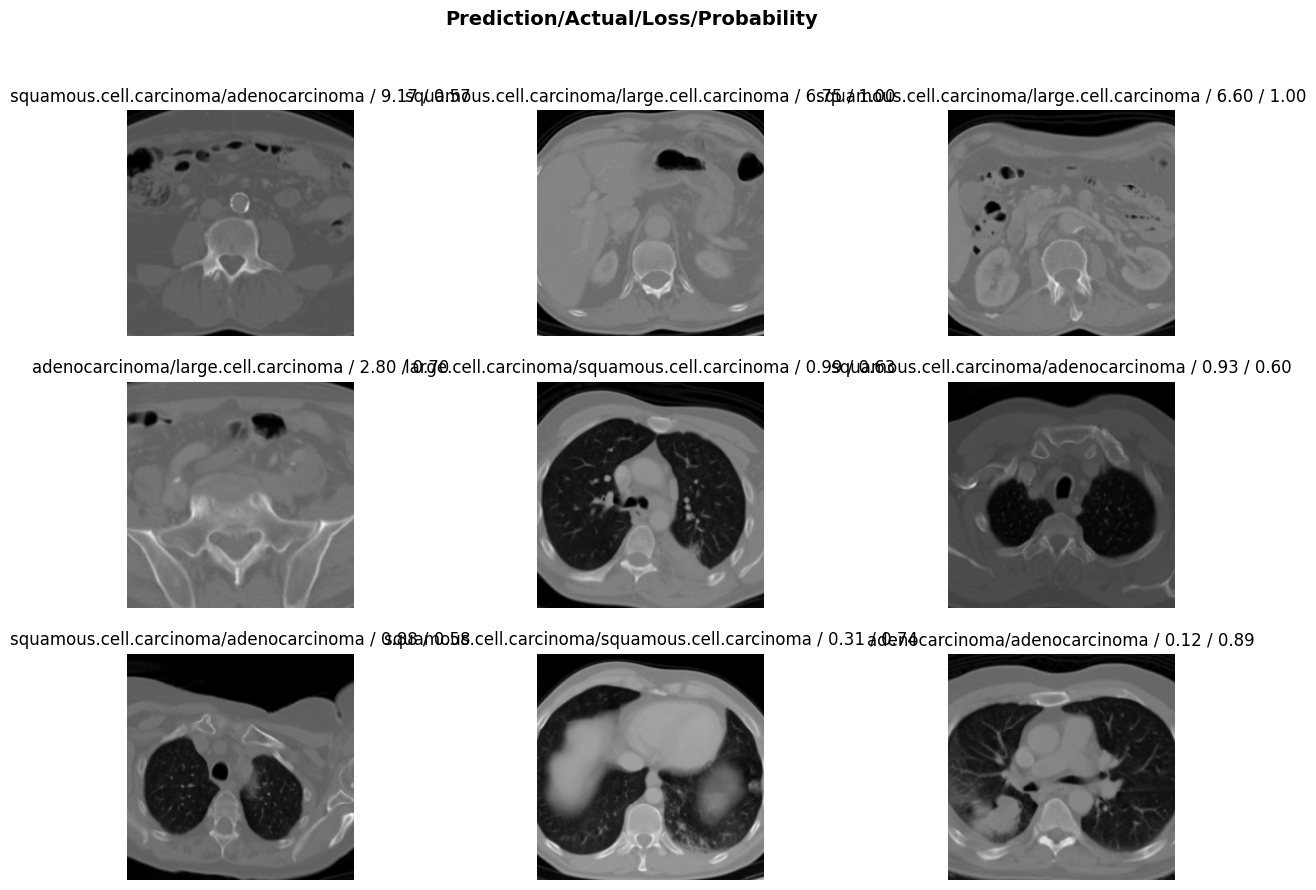

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10)) # TODO: fix overlapping text

In [ ]:
# Define a custom F1 score metric for Fastai
f1score_fastai = skm_to_fastai(f1_score, average='macro')

# Append the F1 score metric
learn.metrics.append(f1score_fastai)

# Validate and print F1 Score
val_f1score = learn.recorder.values[-1][2]  # Index 2 corresponds to the F1 score

print(f"F1 Score: {val_f1score}")

F1 Score: 0.9079545454545455


### Automated Runner

/home/davay/.conda/envs/data5100/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


######################################
RUN: 1
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.755060,1.525710,0.541667,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.963380,0.849487,0.305556,00:02
1,0.814021,0.849876,0.250000,00:02
2,0.626048,0.757526,0.166667,00:02
3,0.509050,0.791118,0.222222,00:02
4,0.426576,0.652117,0.194444,00:02
5,0.370899,0.764183,0.208333,00:02
6,0.370075,0.723925,0.194444,00:02
7,0.286713,0.829048,0.222222,00:02
8,0.239495,0.771949,0.222222,00:02
9,0.218414,0.953192,0.277778,00:02


/tmp/ipykernel_5222/2941019787.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


######################################
RUN: 2
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.696737,1.358213,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.948565,1.189963,0.361111,00:02
1,0.825761,1.006763,0.319444,00:02
2,0.707681,0.994606,0.305556,00:02
3,0.576546,1.100434,0.305556,00:02
4,0.476694,0.918997,0.236111,00:02
5,0.396520,0.792288,0.194444,00:02
6,0.353697,0.855401,0.208333,00:02
7,0.294370,0.836905,0.208333,00:02
8,0.252460,1.332411,0.194444,00:02
9,0.245222,0.566392,0.152778,00:02


######################################
RUN: 3
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.353564,1.317761,0.513889,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.692654,1.139460,0.347222,00:08
1,0.660476,0.930329,0.291667,00:08
2,0.527087,0.913118,0.361111,00:08
3,0.452041,0.827430,0.291667,00:08
4,0.395906,0.780698,0.236111,00:08
5,0.351676,0.630806,0.222222,00:08
6,0.271137,0.727116,0.222222,00:08
7,0.228398,0.766724,0.236111,00:08
8,0.196551,0.672847,0.208333,00:08
9,0.208506,0.913060,0.166667,00:08


######################################
RUN: 4
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.427480,1.281643,0.402778,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.734222,1.791365,0.416667,00:08
1,0.550477,1.229793,0.333333,00:08
2,0.423934,1.267121,0.319444,00:08
3,0.300129,1.224328,0.305556,00:08
4,0.309127,0.893844,0.305556,00:08
5,0.233269,1.303947,0.291667,00:08
6,0.184891,1.378194,0.291667,00:08
7,0.191398,1.154928,0.277778,00:08
8,0.158833,1.787967,0.333333,00:08
9,0.167790,1.365641,0.277778,00:08


######################################
RUN: 5
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.773644,1.762982,0.486111,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.400885,1.157559,0.388889,00:02
1,1.086804,1.132734,0.388889,00:02
2,1.015011,1.114121,0.402778,00:02
3,0.969933,1.090541,0.402778,00:02
4,0.848619,1.102242,0.402778,00:02
5,0.788807,1.132160,0.375000,00:02
6,0.700913,0.899349,0.277778,00:02
7,0.677607,0.731232,0.236111,00:02
8,0.606270,0.720942,0.236111,00:02
9,0.584260,0.829123,0.277778,00:02


######################################
RUN: 6
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.970594,1.713759,0.527778,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.256461,1.047332,0.361111,00:02
1,1.119911,1.106288,0.430556,00:03
2,1.006103,1.132630,0.430556,00:02
3,0.912630,1.074190,0.375000,00:02
4,0.812921,1.082486,0.319444,00:02
5,0.713745,1.078180,0.333333,00:02
6,0.718490,1.311734,0.375000,00:02
7,0.658767,1.435404,0.319444,00:02
8,0.614641,1.270996,0.305556,00:02
9,0.537186,1.134439,0.277778,00:02


######################################
RUN: 7
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.461910,1.492742,0.444444,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.937483,1.174616,0.375000,00:08
1,0.827564,0.974530,0.291667,00:08
2,0.754296,0.929664,0.361111,00:08
3,0.664184,0.774021,0.263889,00:08
4,0.605596,0.897881,0.291667,00:08
5,0.560093,0.910972,0.291667,00:08
6,0.520066,0.749904,0.208333,00:08
7,0.459357,0.760690,0.236111,00:08
8,0.392133,1.055963,0.236111,00:08
9,0.396079,0.790853,0.222222,00:08


######################################
RUN: 8
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.550967,2.313920,0.458333,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.899269,2.020043,0.444444,00:09
1,0.907936,1.570296,0.361111,00:08
2,0.768171,1.472125,0.291667,00:08
3,0.665411,1.404238,0.277778,00:09
4,0.546033,1.006094,0.263889,00:08
5,0.477464,0.926423,0.236111,00:08
6,0.410875,1.346047,0.263889,00:08
7,0.370949,0.924724,0.208333,00:08
8,0.294312,1.283623,0.277778,00:09
9,0.251182,1.040257,0.208333,00:09


######################################
RUN: 9
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.706728,1.893169,0.541667,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.305670,1.347726,0.472222,00:02
1,1.111841,1.101097,0.347222,00:02
2,1.001044,1.042588,0.402778,00:02
3,0.892140,1.084807,0.347222,00:02
4,0.799488,1.041331,0.347222,00:02
5,0.692989,1.465148,0.305556,00:02
6,0.595798,1.152801,0.277778,00:02
7,0.576501,0.826542,0.236111,00:02
8,0.554044,0.823381,0.208333,00:02
9,0.444290,0.954055,0.236111,00:02


######################################
RUN: 10
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.637983,1.434755,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.288957,1.176192,0.388889,00:02
1,1.054853,1.062519,0.347222,00:02
2,0.921117,0.941848,0.319444,00:02
3,0.869852,0.922542,0.277778,00:02
4,0.755298,0.908831,0.305556,00:02
5,0.677643,0.937221,0.388889,00:02
6,0.626648,0.898467,0.319444,00:02
7,0.518266,0.872401,0.236111,00:02
8,0.481417,0.821557,0.263889,00:02
9,0.467979,0.834952,0.291667,00:02


######################################
RUN: 11
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.696527,1.428899,0.444444,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.206023,0.984288,0.319444,00:02
1,1.024558,1.029949,0.333333,00:02
2,0.913444,0.992130,0.263889,00:02
3,0.815401,0.845077,0.263889,00:02
4,0.747147,0.950207,0.236111,00:02
5,0.630256,0.823605,0.250000,00:02
6,0.573377,0.818337,0.208333,00:02
7,0.524815,0.859977,0.250000,00:02
8,0.499055,1.352641,0.250000,00:02
9,0.510605,0.794414,0.208333,00:03


######################################
RUN: 12
BASE MODEL: resnet50
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.752188,2.304234,0.569444,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.144122,1.577369,0.388889,00:03
1,0.898441,1.575731,0.402778,00:02
2,0.793887,1.702960,0.402778,00:02
3,0.667390,1.374156,0.333333,00:02
4,0.621096,1.373846,0.305556,00:02
5,0.565531,1.166161,0.263889,00:03
6,0.490309,1.191319,0.319444,00:03
7,0.432231,0.785069,0.222222,00:02
8,0.347394,0.856430,0.208333,00:03
9,0.328070,0.842419,0.222222,00:02


######################################
RUN: 13
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.115193,1.578503,0.666667,00:02
1,1.778614,1.691812,0.513889,00:02
2,1.546769,1.297711,0.458333,00:02
3,1.304820,1.222045,0.430556,00:02
4,1.122893,0.953286,0.319444,00:02
5,0.916753,1.775734,0.402778,00:02
6,0.800479,1.622538,0.333333,00:02
7,0.681037,1.975988,0.361111,00:02
8,0.685227,2.751856,0.333333,00:02
9,0.607538,1.107485,0.291667,00:02


######################################
RUN: 14
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.064883,1.673429,0.694444,00:02
1,1.764867,1.487179,0.500000,00:02
2,1.526641,1.293884,0.430556,00:02
3,1.308129,1.172073,0.444444,00:02
4,1.083623,1.022938,0.319444,00:02
5,0.936322,1.005048,0.277778,00:02
6,0.822383,0.909531,0.222222,00:02
7,0.678294,0.872933,0.319444,00:02
8,0.650359,0.843352,0.236111,00:02
9,0.603699,1.039497,0.250000,00:02


######################################
RUN: 15
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.847096,1.138593,0.486111,00:07
1,1.525319,1.126420,0.472222,00:07
2,1.281771,1.092786,0.416667,00:07
3,1.108833,1.260157,0.347222,00:07
4,0.884591,1.078333,0.402778,00:07
5,0.784200,1.375145,0.361111,00:07
6,0.676388,1.234874,0.347222,00:07
7,0.593083,1.310347,0.333333,00:07
8,0.536633,0.934792,0.250000,00:07
9,0.482389,1.291505,0.375000,00:07


######################################
RUN: 16
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.716043,1.160944,0.555556,00:07
1,1.413597,1.039869,0.416667,00:07
2,1.217817,1.133132,0.402778,00:07
3,0.993127,1.115389,0.347222,00:07
4,0.843789,1.047324,0.319444,00:07
5,0.648863,1.006010,0.263889,00:07
6,0.530839,1.055183,0.305556,00:07
7,0.488888,1.461459,0.333333,00:07
8,0.440559,1.361383,0.319444,00:07
9,0.417431,0.900629,0.250000,00:07


######################################
RUN: 17
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.129385,1.717758,0.722222,00:02
1,1.895715,1.697687,0.611111,00:02
2,1.663556,1.558718,0.444444,00:02
3,1.434569,1.888757,0.402778,00:02
4,1.236913,2.024335,0.430556,00:02
5,1.128993,1.355911,0.305556,00:02
6,1.080163,1.359369,0.361111,00:02
7,1.017163,1.282242,0.361111,00:02
8,0.976741,1.140454,0.333333,00:02
9,0.929318,1.002674,0.333333,00:02


######################################
RUN: 18
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.993905,1.584171,0.638889,00:02
1,1.852146,1.191985,0.472222,00:02
2,1.576922,0.966970,0.375000,00:02
3,1.390201,0.942762,0.402778,00:02
4,1.323306,1.007306,0.361111,00:02
5,1.197221,1.274419,0.402778,00:02
6,1.190645,1.190268,0.416667,00:02
7,1.020539,1.334031,0.388889,00:02
8,1.031368,1.597250,0.458333,00:02
9,0.965037,1.179958,0.416667,00:02


######################################
RUN: 19
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.871432,1.297136,0.527778,00:07
1,1.620718,1.193297,0.500000,00:07
2,1.340070,1.158800,0.472222,00:07
3,1.196779,1.637306,0.500000,00:07
4,1.066759,1.388352,0.402778,00:07
5,1.024567,1.315210,0.402778,00:07
6,0.936664,1.520516,0.402778,00:07
7,0.837231,1.503325,0.430556,00:07
8,0.776254,1.316688,0.319444,00:07
9,0.742941,1.473737,0.319444,00:07


######################################
RUN: 20
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.761597,1.377357,0.597222,00:07
1,1.487617,1.126157,0.500000,00:07
2,1.337555,1.013187,0.430556,00:07
3,1.173451,0.969757,0.416667,00:07
4,1.102896,1.047734,0.375000,00:07
5,0.934118,1.305449,0.305556,00:07
6,0.817548,1.192882,0.291667,00:07
7,0.792687,1.080703,0.291667,00:07
8,0.740616,1.045867,0.319444,00:07
9,0.656261,1.124565,0.347222,00:07


######################################
RUN: 21
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.200565,1.828209,0.708333,00:02
1,1.889954,1.458903,0.569444,00:02
2,1.621533,1.290021,0.527778,00:02
3,1.444037,1.079229,0.444444,00:02
4,1.226556,1.189586,0.444444,00:02
5,1.149001,1.181393,0.402778,00:02
6,1.037419,1.973355,0.347222,00:02
7,0.949902,1.728227,0.347222,00:02
8,0.929215,1.252850,0.347222,00:02
9,0.857340,1.310482,0.416667,00:02


######################################
RUN: 22
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.257456,1.584153,0.666667,00:02
1,1.885486,1.295284,0.541667,00:02
2,1.609433,1.009214,0.444444,00:02
3,1.451255,0.909681,0.361111,00:02
4,1.320411,0.954227,0.402778,00:02
5,1.172759,0.984176,0.319444,00:02
6,1.120397,1.156863,0.416667,00:02
7,0.949269,1.421283,0.458333,00:02
8,0.870275,0.937318,0.319444,00:02
9,0.894649,0.989477,0.319444,00:02


######################################
RUN: 23
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.057088,1.334844,0.638889,00:02
1,1.841557,1.730381,0.652778,00:02
2,1.555989,1.687615,0.500000,00:02
3,1.359679,1.097690,0.388889,00:02
4,1.218737,0.963045,0.388889,00:02
5,1.057370,1.026014,0.333333,00:02
6,0.926281,0.923375,0.277778,00:02
7,0.863512,1.145465,0.333333,00:02
8,0.823953,1.551357,0.361111,00:02
9,0.807577,1.150611,0.375000,00:02


######################################
RUN: 24
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.136603,1.580240,0.736111,00:02
1,1.822933,1.300747,0.555556,00:02
2,1.550084,1.465208,0.444444,00:02
3,1.321743,1.312690,0.430556,00:02
4,1.159141,1.278281,0.458333,00:02
5,0.970350,1.216403,0.416667,00:02
6,0.889416,0.966312,0.388889,00:02
7,0.803806,0.930891,0.347222,00:02
8,0.828419,1.245121,0.402778,00:02
9,0.736423,1.324352,0.472222,00:02


######################################
RUN: 25
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.116013,1.348509,0.444444,00:02
1,1.711176,0.934447,0.388889,00:02
2,1.389622,0.761054,0.361111,00:02
3,1.140177,0.908057,0.333333,00:02
4,0.934602,0.842805,0.277778,00:02
5,0.817915,1.160383,0.375000,00:02


No improvement since epoch 2: early stopping
######################################
RUN: 26
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.796388,1.325599,0.527778,00:02
1,1.613054,1.161116,0.486111,00:02
2,1.306843,1.086707,0.388889,00:02
3,1.151486,1.139932,0.361111,00:02
4,0.964208,0.921974,0.319444,00:02
5,0.868443,1.468930,0.347222,00:02
6,0.736010,1.934229,0.333333,00:02
7,0.730908,1.815023,0.347222,00:02


No improvement since epoch 4: early stopping
######################################
RUN: 27
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.683007,1.271020,0.583333,00:08
1,1.388133,0.980351,0.416667,00:08
2,1.146780,1.294531,0.361111,00:08
3,0.965897,1.098846,0.347222,00:08
4,0.805645,1.155261,0.333333,00:08


No improvement since epoch 1: early stopping
######################################
RUN: 28
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.943368,1.294689,0.638889,00:08
1,1.612153,1.006499,0.388889,00:08
2,1.384164,0.969176,0.347222,00:08
3,1.222938,0.893950,0.347222,00:08
4,0.951456,0.896127,0.319444,00:08
5,0.794589,0.851094,0.263889,00:08
6,0.648086,1.076438,0.305556,00:08
7,0.559362,0.943455,0.291667,00:08
8,0.485579,1.286346,0.361111,00:08


No improvement since epoch 5: early stopping
######################################
RUN: 29
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.817551,1.361066,0.611111,00:02
1,1.426521,1.366186,0.500000,00:02
2,1.214279,0.973725,0.375000,00:02
3,1.198561,0.968404,0.291667,00:02
4,1.086678,1.314667,0.375000,00:02
5,1.013413,1.534043,0.375000,00:02


No improvement since epoch 2: early stopping
######################################
RUN: 30
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.964550,1.312215,0.513889,00:02
1,1.606400,1.299603,0.430556,00:02
2,1.422565,1.356578,0.388889,00:02
3,1.229000,1.553043,0.361111,00:02
4,1.139571,1.421912,0.375000,00:02


No improvement since epoch 1: early stopping
######################################
RUN: 31
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.936172,1.214634,0.583333,00:08
1,1.530960,1.009299,0.361111,00:08
2,1.313154,1.043622,0.430556,00:08
3,1.118368,1.152428,0.361111,00:08
4,0.950091,0.978959,0.277778,00:08
5,0.876574,0.993652,0.263889,00:08
6,0.847307,1.177756,0.305556,00:08
7,0.783768,0.849734,0.319444,00:07
8,0.722498,0.692370,0.208333,00:07
9,0.673179,0.759025,0.236111,00:07


No improvement since epoch 12: early stopping
######################################
RUN: 32
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.923899,1.311471,0.500000,00:07
1,1.614546,1.125214,0.430556,00:07
2,1.276598,1.036021,0.361111,00:07
3,1.123577,1.061937,0.416667,00:07
4,0.956083,1.251794,0.375000,00:07
5,0.893534,1.163809,0.347222,00:07


No improvement since epoch 2: early stopping
######################################
RUN: 33
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.295842,1.605414,0.722222,00:02
1,2.220680,2.014754,0.777778,00:02
2,2.201128,2.227070,0.708333,00:02
3,2.003467,1.750280,0.708333,00:02


No improvement since epoch 0: early stopping
######################################
RUN: 34
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.985187,1.724283,0.708333,00:02
1,1.819902,1.133653,0.569444,00:02
2,1.590434,0.994602,0.458333,00:02
3,1.318264,0.974813,0.375000,00:02
4,1.238653,0.958418,0.333333,00:02
5,1.158161,1.106345,0.277778,00:02
6,1.036373,1.302329,0.375000,00:02
7,0.971177,1.104757,0.277778,00:02


No improvement since epoch 4: early stopping
######################################
RUN: 35
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.071376,1.428979,0.625000,00:02
1,1.969453,1.447527,0.569444,00:02
2,1.762066,1.175226,0.527778,00:02
3,1.585247,1.065063,0.458333,00:02
4,1.465869,1.104234,0.430556,00:02
5,1.307026,1.017757,0.458333,00:02
6,1.141590,1.030456,0.486111,00:02
7,0.985770,1.065050,0.430556,00:02
8,0.921048,1.127849,0.444444,00:02


No improvement since epoch 5: early stopping
######################################
RUN: 36
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.421825,1.716265,0.708333,00:02
1,2.330382,1.989776,0.694444,00:02
2,2.165789,2.690494,0.625000,00:02
3,1.959781,2.236762,0.569444,00:02


No improvement since epoch 0: early stopping
######################################
RUN: 37
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.739517,1.482715,0.458333,00:02
1,1.353832,1.496135,0.486111,00:02
2,1.072260,2.032132,0.500000,00:02
3,0.945508,2.204311,0.388889,00:02


No improvement since epoch 0: early stopping
######################################
RUN: 38
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.802963,1.333063,0.583333,00:02
1,1.474046,0.901521,0.361111,00:02
2,1.172279,0.892902,0.333333,00:02
3,0.950826,0.982624,0.361111,00:02
4,0.820645,1.070926,0.375000,00:02


No improvement since epoch 1: early stopping
######################################
RUN: 39
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.431740,1.243055,0.416667,00:07
1,1.025782,1.150128,0.277778,00:07
2,0.827627,0.931931,0.277778,00:07
3,0.652369,1.018757,0.263889,00:07
4,0.616095,1.060473,0.347222,00:07
5,0.519005,0.922311,0.333333,00:07


No improvement since epoch 2: early stopping
######################################
RUN: 40
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.413348,1.170887,0.444444,00:07
1,1.018331,1.029865,0.375000,00:07
2,0.785841,1.323440,0.333333,00:07
3,0.624608,1.340831,0.319444,00:07
4,0.527778,1.130233,0.333333,00:07


No improvement since epoch 1: early stopping
######################################
RUN: 41
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.932016,1.497238,0.652778,00:02
1,1.579977,1.261273,0.513889,00:02
2,1.394384,1.189982,0.472222,00:02
3,1.346156,1.037478,0.402778,00:02
4,1.215160,1.155861,0.458333,00:02
5,1.143257,1.188306,0.375000,00:02
6,1.092152,1.179129,0.347222,00:02


No improvement since epoch 3: early stopping
######################################
RUN: 42
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.865774,1.234062,0.555556,00:02
1,1.482862,1.073121,0.458333,00:02
2,1.383061,1.327586,0.402778,00:02
3,1.227301,1.048890,0.388889,00:02
4,1.092466,1.638612,0.444444,00:02
5,1.052372,1.235181,0.319444,00:02
6,1.015936,1.222492,0.375000,00:02


No improvement since epoch 3: early stopping
######################################
RUN: 43
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.707081,1.096342,0.444444,00:07
1,1.368731,0.811900,0.361111,00:07
2,1.205311,0.731607,0.319444,00:07
3,1.083214,0.919195,0.375000,00:07
4,0.947696,0.831028,0.319444,00:07
5,0.884211,1.144013,0.375000,00:07


No improvement since epoch 2: early stopping
######################################
RUN: 44
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.838938,1.730751,0.569444,00:07
1,1.461240,1.140527,0.444444,00:07
2,1.288585,1.185469,0.388889,00:07
3,1.103922,1.149997,0.402778,00:07
4,0.942824,1.403812,0.375000,00:07


No improvement since epoch 1: early stopping
######################################
RUN: 45
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


/home/davay/.conda/envs/data5100/lib/python3.11/site-packages/fastai/callback/schedule.py:272: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,error_rate,time
0,1.743995,1.270121,0.458333,00:02
1,1.368637,1.373117,0.402778,00:02
2,1.079749,1.080893,0.347222,00:02
3,1.024433,1.461294,0.402778,00:02
4,0.962595,1.154794,0.416667,00:02
5,0.838425,1.969961,0.444444,00:02


No improvement since epoch 2: early stopping
######################################
RUN: 46
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.905704,1.432472,0.597222,00:02
1,1.551309,1.012282,0.388889,00:02
2,1.319671,1.676185,0.388889,00:02
3,1.220365,1.241479,0.333333,00:02
4,1.158840,0.979944,0.333333,00:02
5,1.004000,1.071304,0.319444,00:02
6,0.911864,2.665856,0.402778,00:02
7,0.904023,1.212516,0.277778,00:02


No improvement since epoch 4: early stopping
######################################
RUN: 47
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.732339,1.003460,0.430556,00:02
1,1.456414,0.880295,0.375000,00:02
2,1.313609,0.940497,0.347222,00:02
3,1.109326,1.023557,0.361111,00:02
4,0.935800,0.960965,0.319444,00:02


No improvement since epoch 1: early stopping
######################################
RUN: 48
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'div': 10, 'early_stop': {'patience': 3}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.742954,1.195769,0.472222,00:02
1,1.438033,1.399394,0.472222,00:02
2,1.266055,1.337362,0.444444,00:02
3,1.111327,1.429922,0.402778,00:02


No improvement since epoch 0: early stopping
######################################
RUN: 49
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.269537,1.820626,0.777778,00:02
1,1.955019,1.384834,0.583333,00:02
2,1.705610,1.203154,0.500000,00:02
3,1.515170,1.018234,0.486111,00:02
4,1.310807,1.135908,0.416667,00:02
5,1.110929,0.959855,0.402778,00:02
6,0.876765,0.991662,0.347222,00:02
7,0.821077,0.890256,0.250000,00:02
8,0.744249,0.676625,0.236111,00:02
9,0.669636,0.914438,0.263889,00:02


No improvement since epoch 15: early stopping
######################################
RUN: 50
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.236807,1.502976,0.680556,00:02
1,1.793447,1.269317,0.500000,00:02
2,1.555590,1.107819,0.444444,00:02
3,1.334435,0.948087,0.430556,00:02
4,1.139156,0.945125,0.347222,00:02
5,0.980306,0.921298,0.319444,00:02
6,0.825769,0.868111,0.375000,00:02
7,0.721757,1.152728,0.347222,00:02
8,0.686252,0.867383,0.250000,00:02
9,0.660880,0.999239,0.319444,00:02


No improvement since epoch 15: early stopping
######################################
RUN: 51
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.860900,1.210448,0.486111,00:07
1,1.736068,1.171733,0.583333,00:07
2,1.461415,1.239027,0.500000,00:08
3,1.187274,1.230179,0.472222,00:08
4,0.966972,1.145136,0.444444,00:08
5,0.901759,1.168127,0.319444,00:07
6,0.788490,1.288488,0.388889,00:07
7,0.690558,0.951688,0.305556,00:07
8,0.605576,1.138131,0.333333,00:07
9,0.533137,1.287809,0.277778,00:07


No improvement since epoch 26: early stopping
######################################
RUN: 52
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: None
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.541906,0.967881,0.430556,00:08
1,1.140488,1.012389,0.319444,00:07
2,0.844164,1.434400,0.333333,00:07
3,0.675838,1.474267,0.319444,00:07
4,0.582166,1.589376,0.333333,00:07
5,0.503047,1.586392,0.291667,00:07
6,0.510719,0.791866,0.263889,00:07
7,0.452244,1.596965,0.291667,00:07
8,0.411636,1.643601,0.361111,00:07
9,0.387502,2.107073,0.347222,00:07


No improvement since epoch 6: early stopping
######################################
RUN: 53
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.920321,1.458720,0.597222,00:02
1,1.637109,1.224675,0.541667,00:02
2,1.467527,0.973637,0.416667,00:02
3,1.334167,0.986785,0.361111,00:02
4,1.175981,0.962928,0.361111,00:02
5,1.108012,1.490100,0.430556,00:02
6,1.037487,1.170363,0.347222,00:02
7,0.975952,1.331584,0.361111,00:02
8,0.881578,1.590759,0.402778,00:02
9,0.833916,0.879614,0.361111,00:02


No improvement since epoch 21: early stopping
######################################
RUN: 54
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.153436,1.470739,0.638889,00:02
1,1.760143,1.185991,0.472222,00:02
2,1.500522,1.104979,0.430556,00:02
3,1.293122,1.380215,0.527778,00:02
4,1.195850,1.187959,0.375000,00:02
5,1.077375,1.416796,0.458333,00:02
6,0.970531,1.120758,0.375000,00:02
7,0.965469,1.118437,0.402778,00:02
8,0.928437,0.996517,0.347222,00:02
9,0.865347,1.050580,0.375000,00:02


No improvement since epoch 29: early stopping
######################################
RUN: 55
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.893278,1.467684,0.555556,00:08
1,1.753236,1.192599,0.416667,00:08
2,1.541977,1.283805,0.458333,00:08
3,1.366944,1.248537,0.402778,00:08
4,1.181456,1.147410,0.347222,00:08
5,1.047946,1.789026,0.402778,00:08
6,0.995782,1.549551,0.416667,00:08
7,0.858456,1.111783,0.388889,00:08
8,0.803916,0.924510,0.305556,00:08
9,0.721401,1.143399,0.388889,00:08


No improvement since epoch 16: early stopping
######################################
RUN: 56
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: aug_transforms()
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.792650,1.480258,0.541667,00:08
1,1.627331,0.921392,0.458333,00:08
2,1.410471,0.929678,0.388889,00:08
3,1.175916,1.117910,0.388889,00:08
4,1.091824,1.063629,0.347222,00:08
5,0.962398,0.979781,0.375000,00:08
6,0.822736,1.170641,0.402778,00:08
7,0.817856,0.810666,0.319444,00:08
8,0.721636,0.928310,0.291667,00:08
9,0.665275,1.158968,0.333333,00:08


No improvement since epoch 7: early stopping
######################################
RUN: 57
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.983514,1.479188,0.611111,00:02
1,1.598220,0.981236,0.416667,00:02
2,1.333152,1.143632,0.458333,00:02
3,1.216745,1.050055,0.458333,00:02
4,1.075668,0.944409,0.319444,00:02
5,0.990124,1.329756,0.444444,00:02
6,0.913487,1.160362,0.402778,00:02
7,0.828290,1.069495,0.347222,00:02
8,0.829473,1.226649,0.347222,00:02
9,0.768691,0.945923,0.236111,00:02


No improvement since epoch 11: early stopping
######################################
RUN: 58
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(224, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,2.187773,1.508445,0.694444,00:02
1,1.859955,1.274254,0.555556,00:02
2,1.661782,1.110714,0.472222,00:02
3,1.517720,0.994115,0.458333,00:02
4,1.356571,1.119805,0.402778,00:02
5,1.157181,0.976471,0.375000,00:02
6,1.077522,0.979359,0.388889,00:02
7,0.996523,1.086035,0.361111,00:02
8,0.903607,1.032808,0.361111,00:02
9,0.860649,1.084790,0.333333,00:02


No improvement since epoch 33: early stopping
######################################
RUN: 59
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: Resize(450, pad_mode='zeros')
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.750656,1.078633,0.458333,00:02
1,1.356577,1.017145,0.333333,00:02
2,1.148798,1.406256,0.416667,00:02
3,1.067943,1.468342,0.333333,00:02
4,1.059192,1.531992,0.361111,00:02
5,0.974823,1.125204,0.375000,00:02
6,0.866433,1.478517,0.388889,00:02
7,0.761594,1.042598,0.375000,00:02
8,0.701457,1.003941,0.305556,00:02
9,0.678265,1.020467,0.263889,00:02


No improvement since epoch 34: early stopping
######################################
RUN: 60
BASE MODEL: resnet50
FIT OPTION: {'method': 'fit_one_cycle', 'n_epoch': 50, 'lr_max': 'lr_find().valley', 'early_stop': {'patience': 10}}
ITEM TFMS: RandomResizedCrop(450, min_scale=0.75)
BATCH TFMS: [*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]
######################################


epoch,train_loss,valid_loss,error_rate,time
0,1.808733,1.065275,0.458333,00:02
1,1.434469,1.151411,0.388889,00:02
2,1.092818,2.274810,0.500000,00:02
3,0.981251,3.198473,0.402778,00:02
4,0.853944,1.540820,0.333333,00:02
5,0.789426,0.996881,0.305556,00:02
6,0.781072,1.470753,0.305556,00:02
7,0.720588,1.113807,0.305556,00:02
8,0.669306,1.572260,0.388889,00:02
9,0.667247,1.124677,0.305556,00:02


No improvement since epoch 13: early stopping


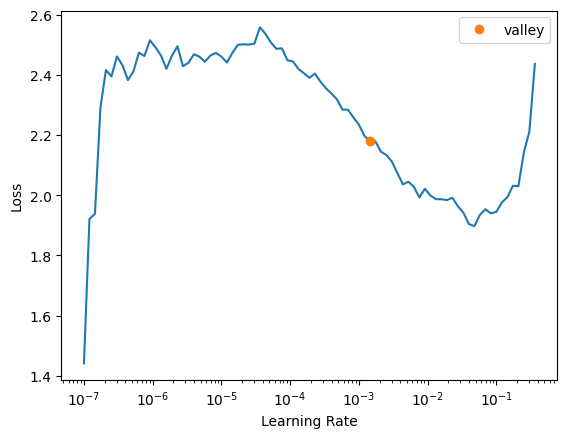

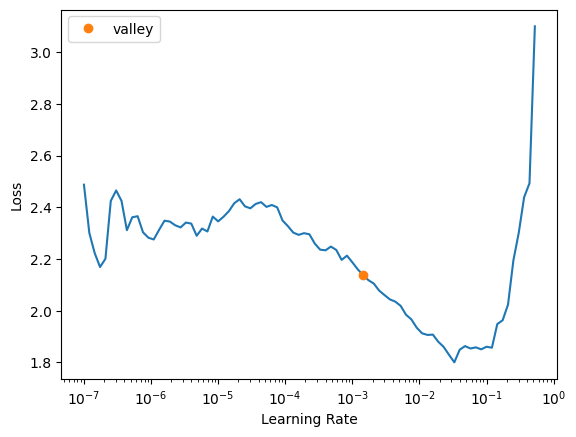

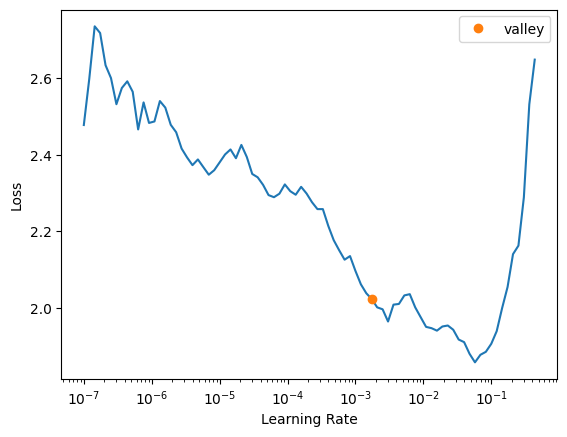

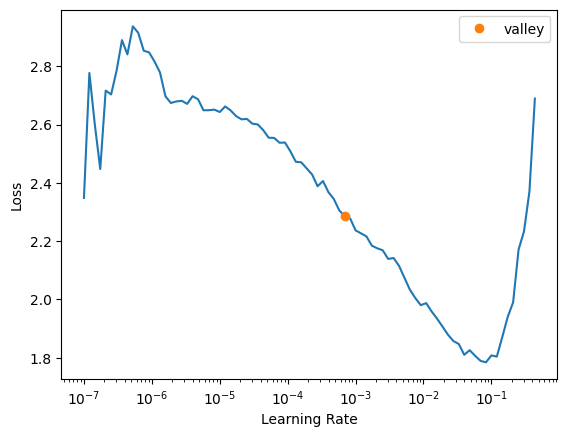

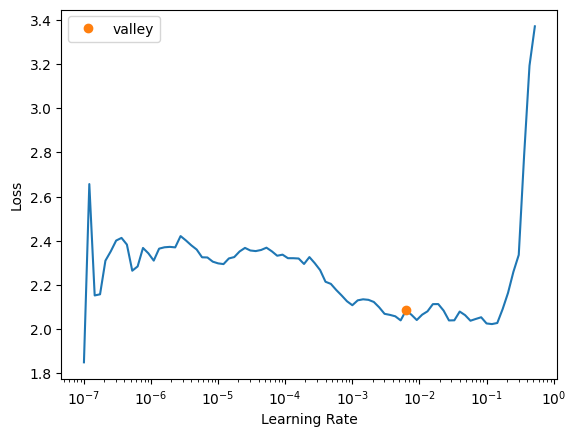

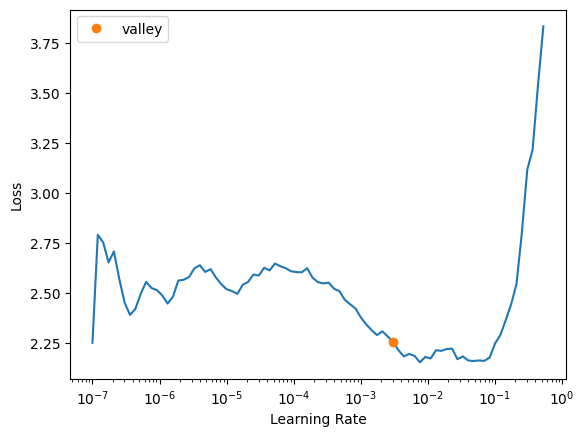

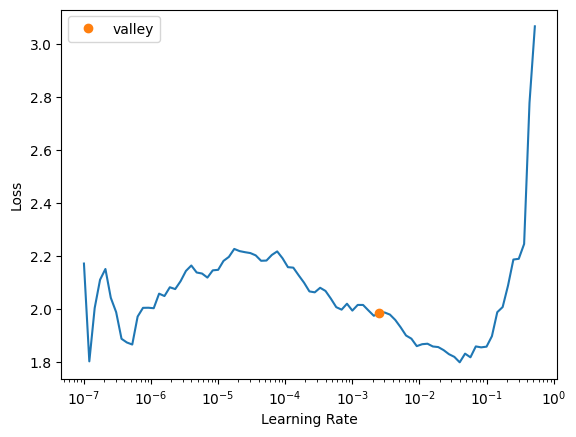

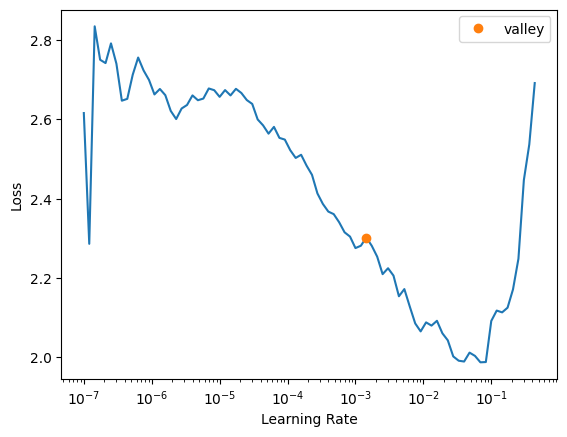

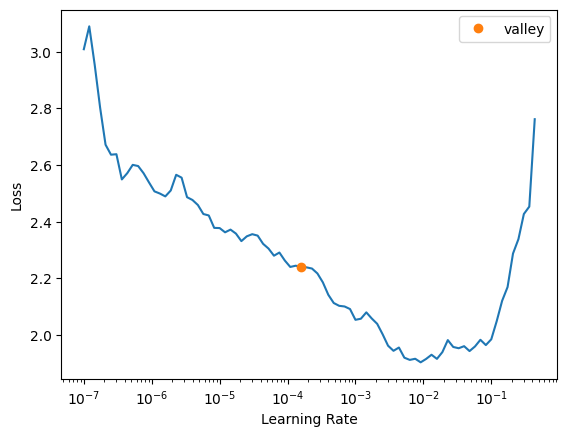

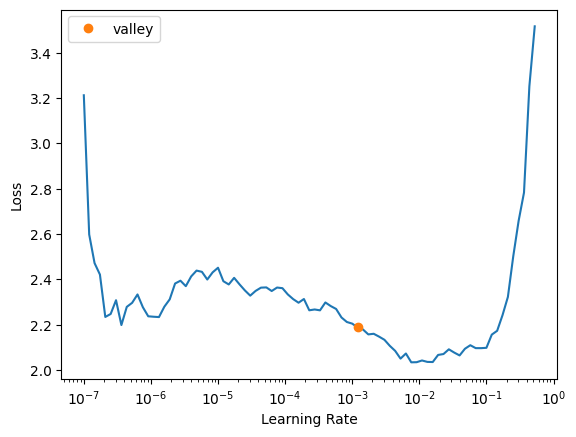

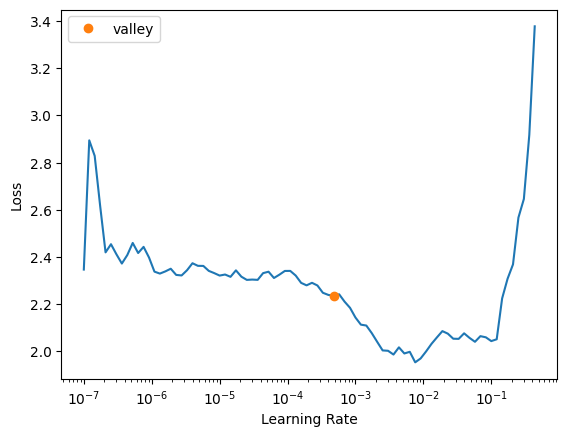

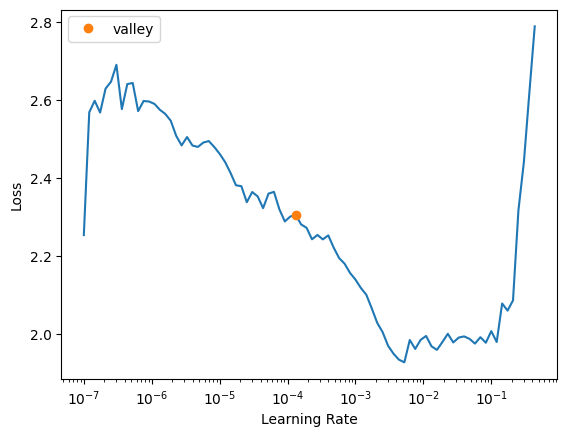

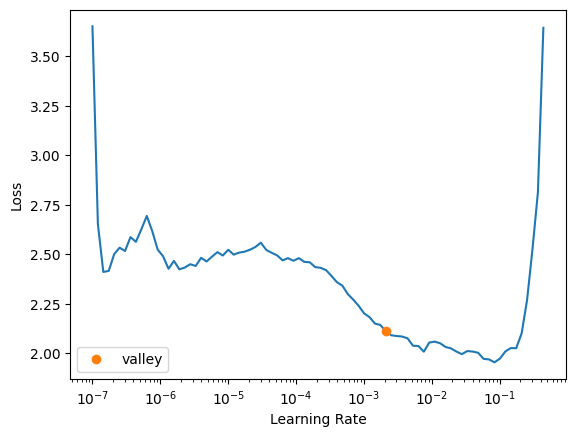

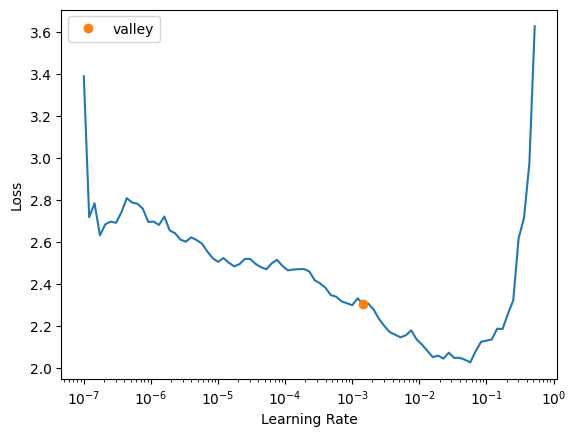

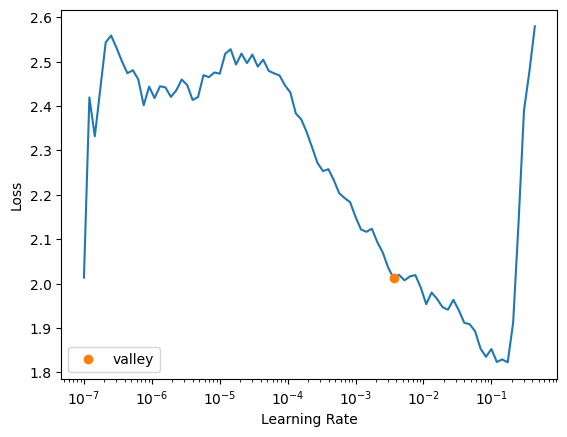

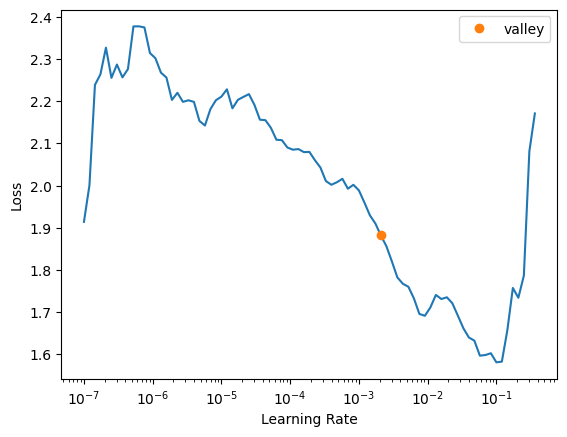

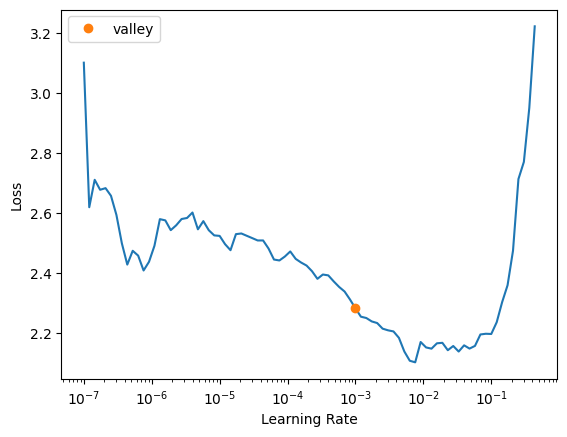

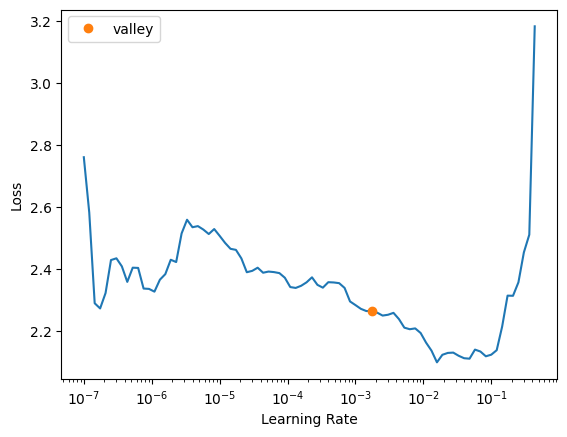

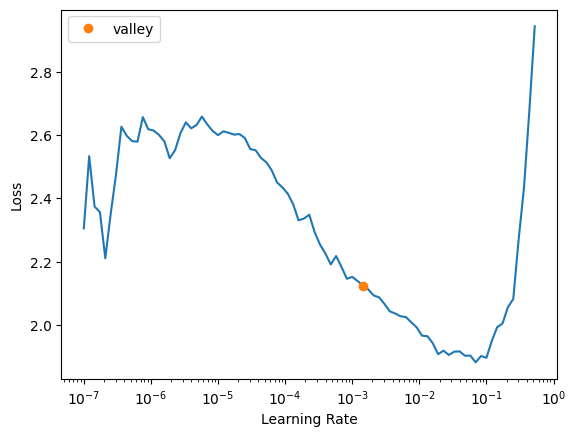

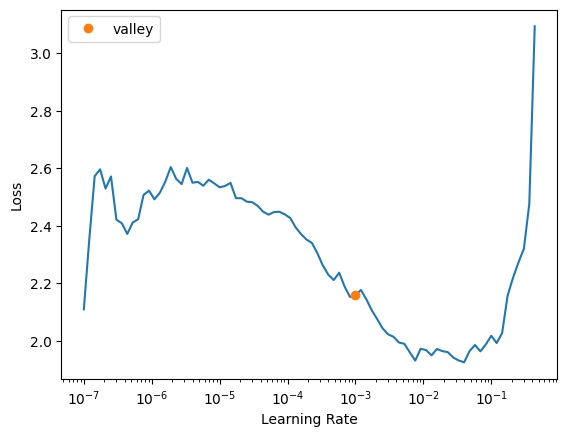

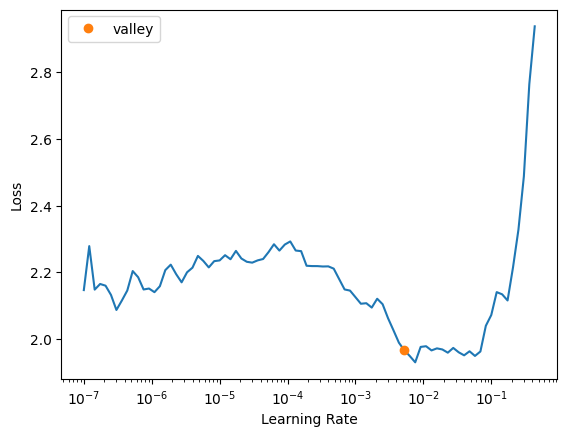

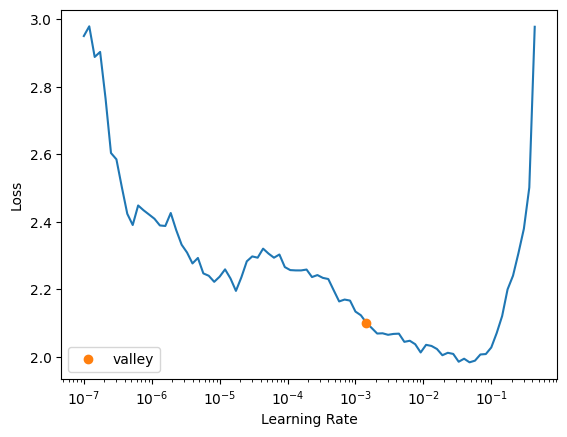

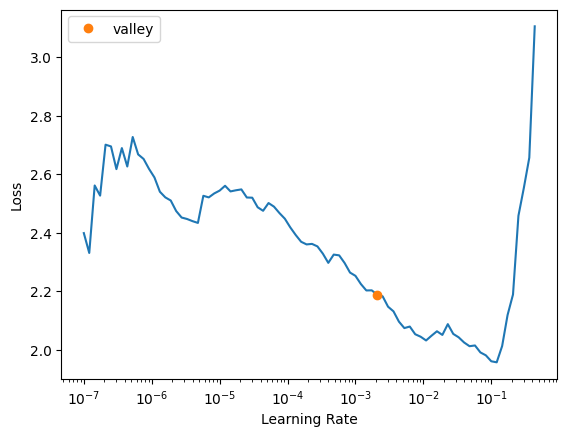

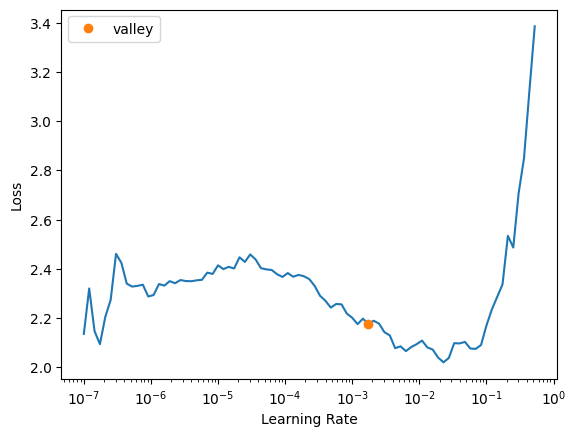

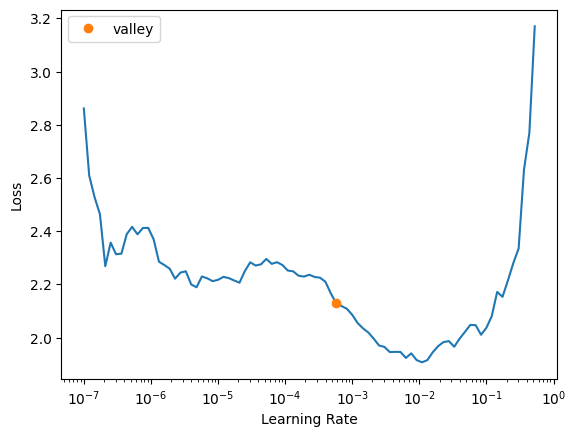

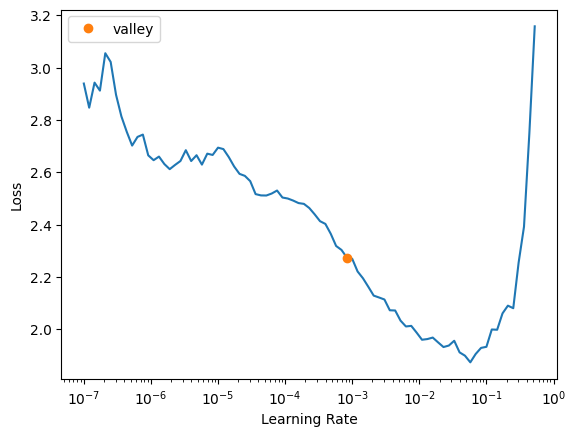

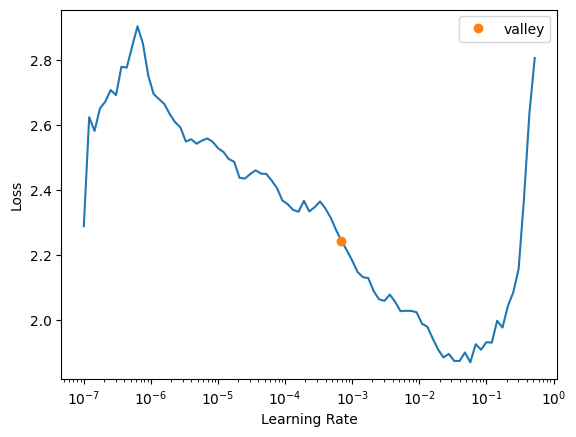

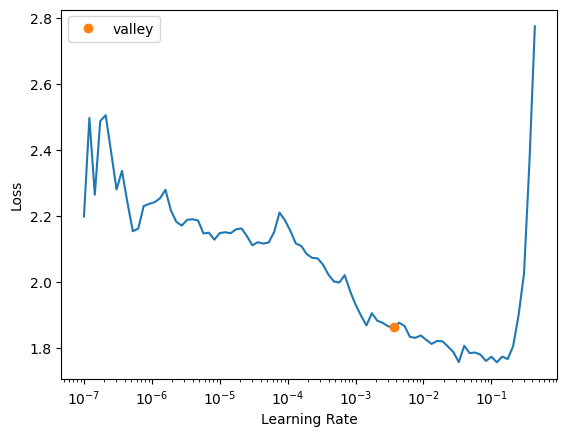

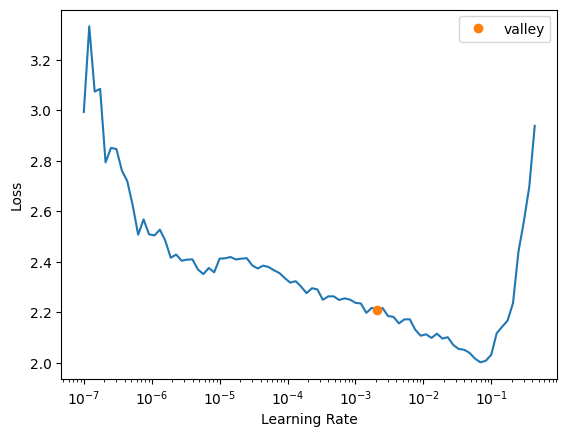

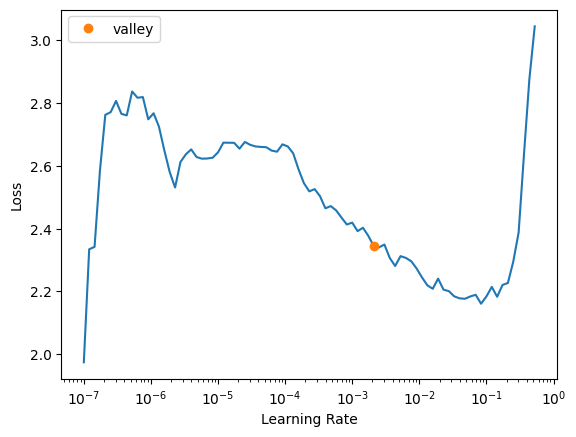

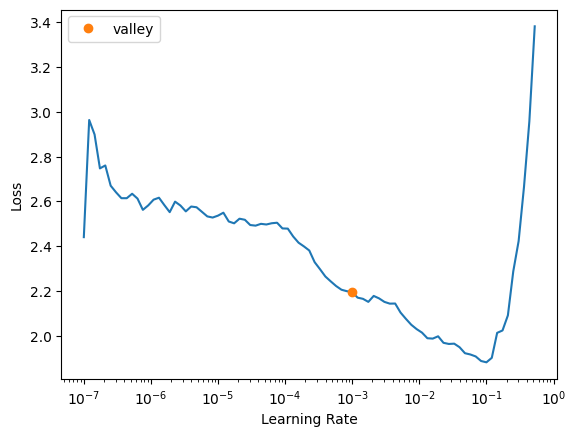

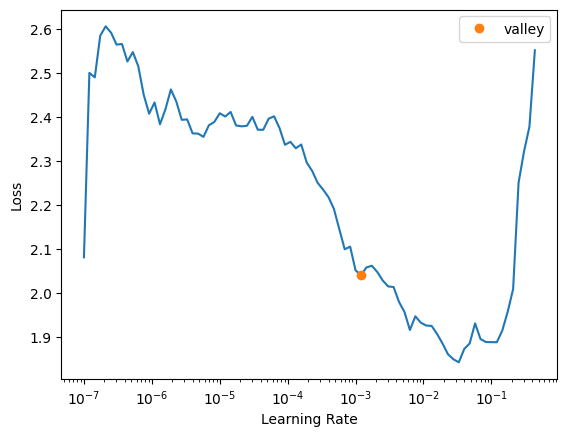

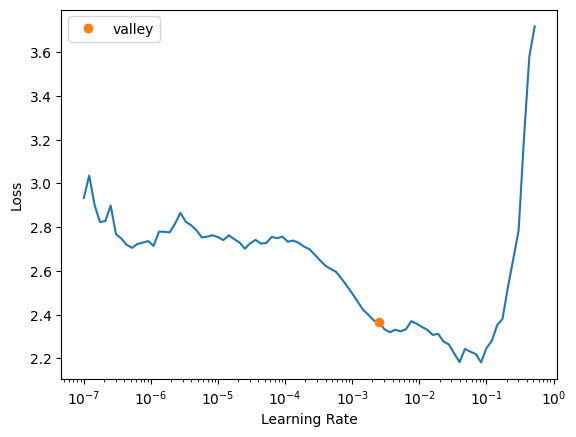

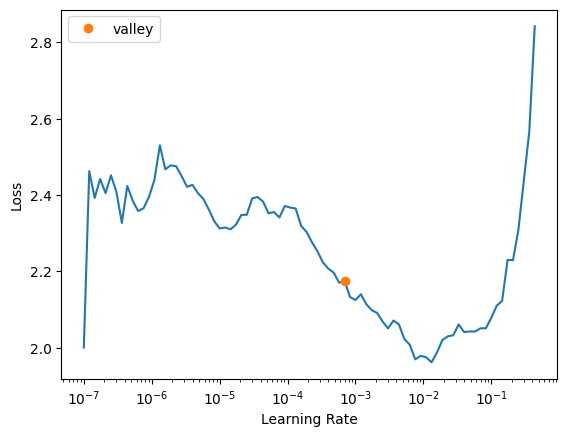

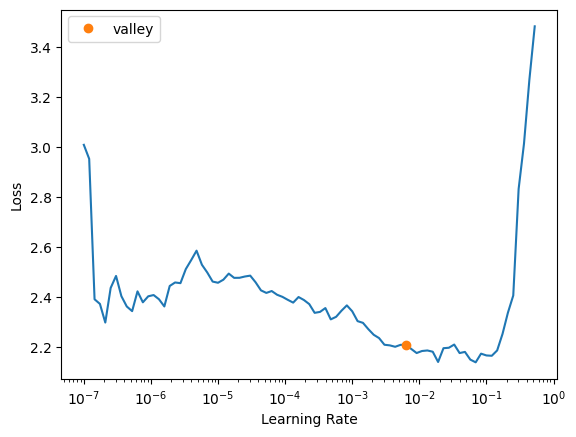

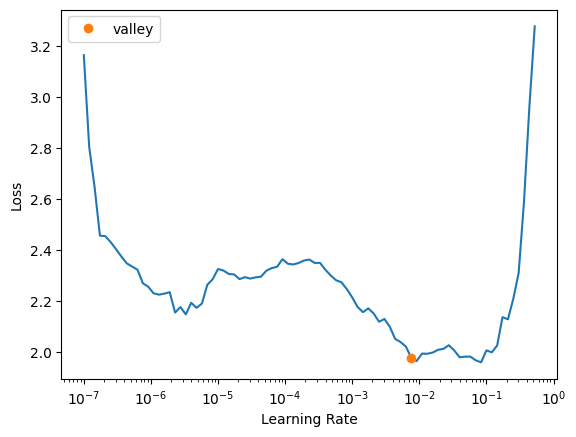

In [1]:
from fastai.vision.all import *
from fastcore.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import f1_score

base_models = [
    # resnet18,
    # resnet50,
    resnet152,
    # densenet121, 
    # densenet201
    ]

fit_options = [
    {"method": "fine_tune", "n_epoch": 50}, 
    {"method": "fit_one_cycle", "n_epoch": 50},
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "early_stop": {"patience": 3}},
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "div": 10, "early_stop": {"patience": 3}}, # this is per resnet paper <link>
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "early_stop": {"patience": 10}},
]

item_tfms_options = [
    "Resize(224)", # using default center crop
    "Resize(224, pad_mode='zeros')",
    "Resize(450, pad_mode='zeros')",
    "RandomResizedCrop(450, min_scale=0.75)" # from fastai paper https://arxiv.org/abs/2002.04688
    ]

batch_tfms_options = [
    "None",
    "aug_transforms()", 
    "[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]" # from fastai paper https://arxiv.org/abs/2002.04688
    ]

def evaluate(learner):
    f1score_fastai = skm_to_fastai(f1_score, average='macro')
    learner.metrics.append(f1score_fastai)
    f1 = learner.recorder.values[-1][2] # Index 2 corresponds to the F1 score
    return f1

path = 'data' # local
# path = 'data5100/data' # google colab

# Iterate over all combinations
n = 1
for base_model in base_models:
    
    # Initialize new data frame per base model, we will separate the csv because there is a chance some runs intermittently fail after a few hundred runs
    results = pd.DataFrame(columns=["Base Model", "Fit Method", "n_epoch", "lr_max", "div", "patience", "item_tfms", "batch_tfms", "F1 Score"])

    for fit_option in fit_options:
        for batch_tfms in batch_tfms_options:
            for item_tfms in item_tfms_options:
                print("######################################")
                print(f"RUN: {n}")
                print(f"BASE MODEL: {base_model.__name__}") 
                print(f"FIT OPTION: {fit_option}")
                print(f"ITEM TFMS: {item_tfms}") 
                print(f"BATCH TFMS: {batch_tfms}")
                print("######################################")
                n += 1

                # Data Prep
                exec(f"item_tfms_obj = {item_tfms}") # Hacky way to grab the pre-evaluated option for cleaner output
                exec(f"batch_tfms_obj = {batch_tfms}")
                dls = ImageDataLoaders.from_folder(
                    path,
                    train='train',
                    valid='valid',
                    test='test',
                    item_tfms=item_tfms_obj,
                    batch_tfms=batch_tfms_obj,
                    bs=16) # default batch size is 64, local runs out of memory sometimes
                
                # Modelling
                learn = vision_learner(dls, base_model, metrics=error_rate)
                lr_valley = learn.lr_find().valley if fit_option.get("lr_max", None) == "lr_find().valley" else None
                early_stop_params = fit_option.get("early_stop", None)
                cbs = EarlyStoppingCallback(
                    monitor='valid_loss', 
                    min_delta=0.01, 
                    patience=early_stop_params.get("patience", 1) # default patience value is 1 - shouldn't get used tho
                ) if early_stop_params else None
                div = fit_option.get("div", 25)
                
                if fit_option["method"] == "fit_one_cycle":
                    learn.fit_one_cycle(fit_option["n_epoch"], lr_valley, div=div if div else None, cbs=cbs if cbs else None)

                if fit_option["method"] == "fine_tune":
                    learn.fine_tune(fit_option["n_epoch"])

                # Evaluation
                f1 = evaluate(learn)
                results = pd.concat([results, pd.DataFrame([{
                    "Base Model": base_model.__name__,
                    "Fit Method": fit_option["method"],
                    "n_epoch": fit_option["n_epoch"],
                    "lr_max": str(fit_option.get("lr_max", None)) + f" -> {lr_valley}",
                    "div": fit_option.get("div", 25),
                    "patience": fit_option["early_stop"]["patience"] if fit_option.get("early_stop", None) else 1, # TODO: TECHNICALLYYYY patience should be None in output if early stop dont exist, because it dont get used
                    "item_tfms": item_tfms,
                    "batch_tfms": batch_tfms,
                    "F1 Score": f1
                }])], ignore_index=True)

    results.to_csv(f"{base_model.__name__}.csv")


# TODO: explore learn.destroy() after every loop to free up memory, or torch.cuda.empty_cache()45